# Parte I: Análisis exploratorio

In [57]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from wordcloud import WordCloud
from gensim.models import KeyedVectors
import re

# suprimir future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 37
np.random.seed(SEED)
random.seed(SEED)
CUSTOM_PALLETE = ["#00A7E1", "#FFA630"]


In [58]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [59]:
print('Shape:', df.shape)
df.describe()

Shape: (7613, 5)


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [60]:
target_sum = df['target'].sum()
print(f"Cantidad de tweets \"Desastre\": {target_sum}")
print(f"Cantidad de tweets \"No Desastre\": {df['target'].count() - target_sum}")

Cantidad de tweets "Desastre": 3271
Cantidad de tweets "No Desastre": 4342


In [61]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].fillna('no_location_contained')
df[['id','text','text_clean','keyword','location','target']].head()


,id,text,text_clean,keyword,location,target
0,1,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...,no_keyword_contained,no_location_contained,1
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,no_keyword_contained,no_location_contained,1
2,5,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,no_keyword_contained,no_location_contained,1
3,6,"13,000 people receive #wildfires evacuation or...",13 000 people receive #wildfires evacuation or...,no_keyword_contained,no_location_contained,1
4,7,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...,no_keyword_contained,no_location_contained,1


In [62]:
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)

df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

df[['text_len','word_count','mean_word_len','num_hashtags','num_mentions','has_url','disaster_terms_count', 'all_caps_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,7613.0,70.222645,26.389220,5.0,50.000000,72.00,91.000000,125.0
word_count,7613.0,14.664259,6.125010,1.0,10.000000,15.00,19.000000,34.0
mean_word_len,7613.0,4.968473,1.064258,2.0,4.235294,4.85,5.526316,13.0
num_hashtags,7613.0,0.446999,1.099841,0.0,0.000000,0.00,0.000000,13.0
num_mentions,7613.0,0.362406,0.720097,0.0,0.000000,0.00,1.000000,8.0
has_url,7613.0,0.521608,0.499566,0.0,0.000000,1.00,1.000000,1.0
disaster_terms_count,7613.0,1.374097,0.866296,0.0,1.000000,1.00,2.000000,7.0
all_caps_count,7613.0,0.933929,2.010867,0.0,0.000000,0.00,1.000000,25.0


## Visualizaciones

### 1. Distribución de longitudes del tweet según target

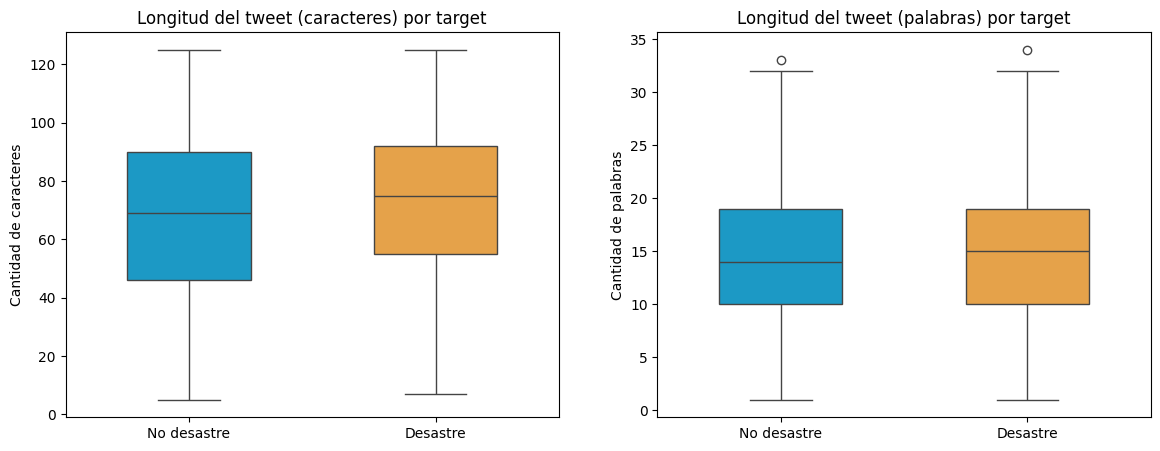

In [63]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='target', y='text_len', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[0])
axes[0].set_title('Longitud del tweet (caracteres) por target')
axes[0].set_xlabel('')
axes[0].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[0].set_ylabel('Cantidad de caracteres')

sns.boxplot(x='target', y='word_count', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[1])
axes[1].set_title('Longitud del tweet (palabras) por target')
axes[1].set_xlabel('')
axes[1].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[1].set_ylabel('Cantidad de palabras')
plt.show()


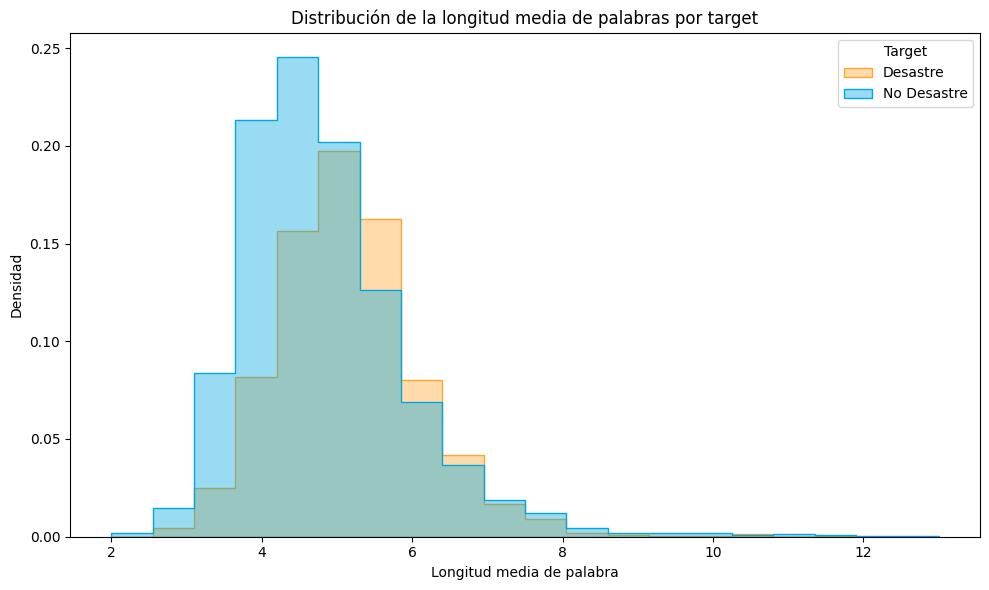

In [64]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='mean_word_len',
    hue='target',
    bins=20,
    palette=CUSTOM_PALLETE,
    alpha=0.4,
    element='step',
    stat='density',
)
plt.title('Distribución de la longitud media de palabras por target')
plt.xlabel('Longitud media de palabra')
plt.ylabel('Densidad')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.tight_layout()
plt.show()

### 2. Proporciíon de tweets según si la ubicación del user es o no es mencionada en el tweet.

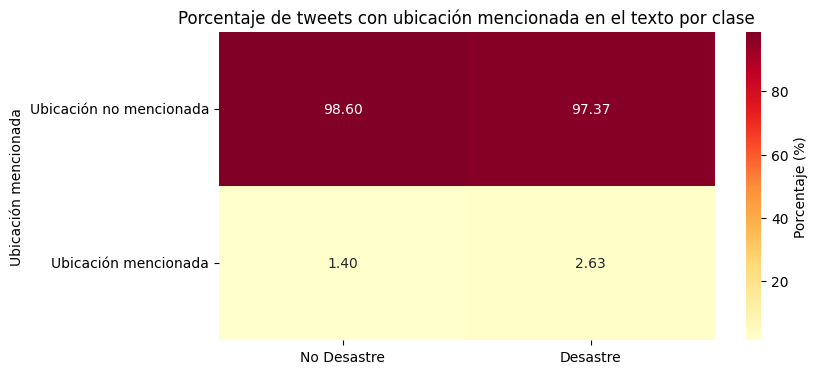

In [65]:
df['location'] = df['location'].apply(clean_text)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)
df[['location','location_mentioned']].value_counts()
location_mentioned_by_target = pd.crosstab(df['location_mentioned'], df['target'], normalize='columns') * 100
location_mentioned_by_target.index = ['Ubicación no mencionada', 'Ubicación mencionada']
location_mentioned_by_target.columns = ['No Desastre', 'Desastre']

plt.figure(figsize=(8, 4))
sns.heatmap(location_mentioned_by_target, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.title('Porcentaje de tweets con ubicación mencionada en el texto por clase')
plt.ylabel('Ubicación mencionada')
plt.yticks(rotation=0)
plt.show()

### 3. Proporción de tweets con URL / hashtags / mentions según target

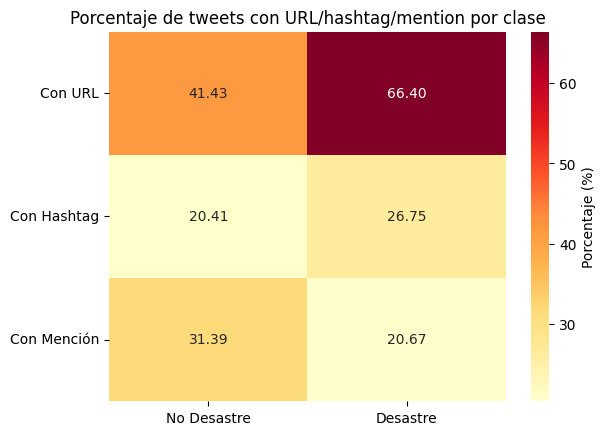

In [66]:
data = pd.DataFrame({
    'Con URL': df.groupby('target')['has_url'].mean()*100,
    'Con Hashtag': (df['num_hashtags']>0).groupby(df['target']).mean()*100,
    'Con Mención': (df['num_mentions']>0).groupby(df['target']).mean()*100
})
data = data.T
data.columns = ['No Desastre','Desastre']
sns.heatmap(data, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.title('Porcentaje de tweets con URL/hashtag/mention por clase')
plt.yticks(rotation=0)
plt.show()


### 4. Cantidad de tweets según cantidad de términos relacionados a desastres y cantidad de palabras en mayúsculas por target

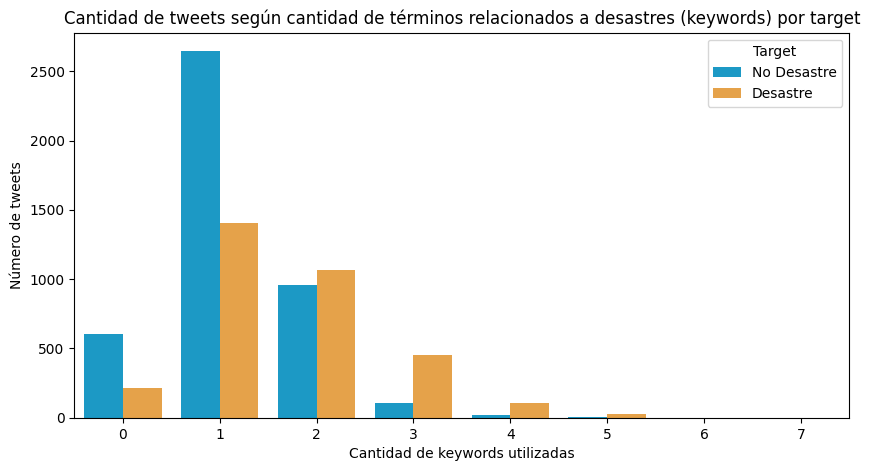

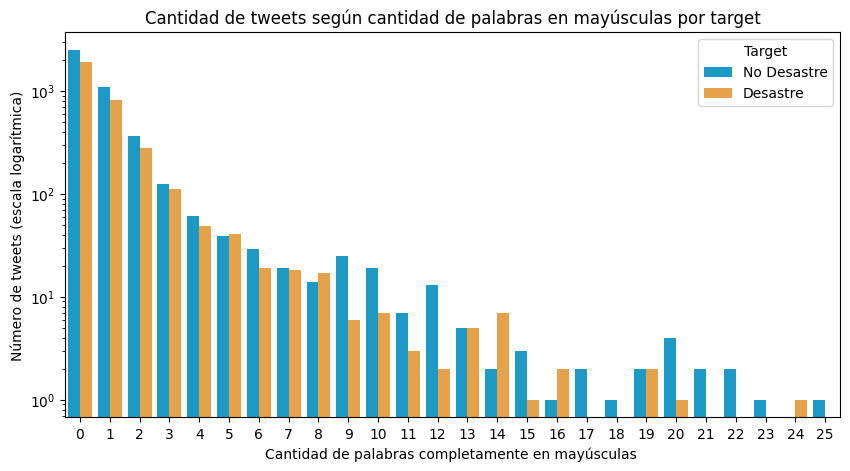

In [67]:
plt.figure(figsize=(10,5))
data = df.groupby(['disaster_terms_count','target']).size().reset_index(name='count')
data['target'] = data['target'].apply(lambda x: "No Desastre" if x == 0 else "Desastre")
sns.barplot(hue='target', x='disaster_terms_count', y='count', data=data, palette=CUSTOM_PALLETE)
plt.title('Cantidad de tweets según cantidad de términos relacionados a desastres (keywords) por target')
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Número de tweets')
plt.legend(title="Target")
plt.show()

plt.figure(figsize=(10,5))
data = df.groupby(['all_caps_count','target']).size().reset_index(name='count')
data['target'] = data['target'].apply(lambda x: "No Desastre" if x == 0 else "Desastre")
sns.barplot(hue='target', x='all_caps_count', y='count', data=data, palette=CUSTOM_PALLETE)
plt.title('Cantidad de tweets según cantidad de palabras en mayúsculas por target')
plt.xlabel('Cantidad de palabras completamente en mayúsculas ')
plt.ylabel('Número de tweets (escala logarítmica)')
plt.yscale('log')
plt.legend(title="Target")
plt.show()

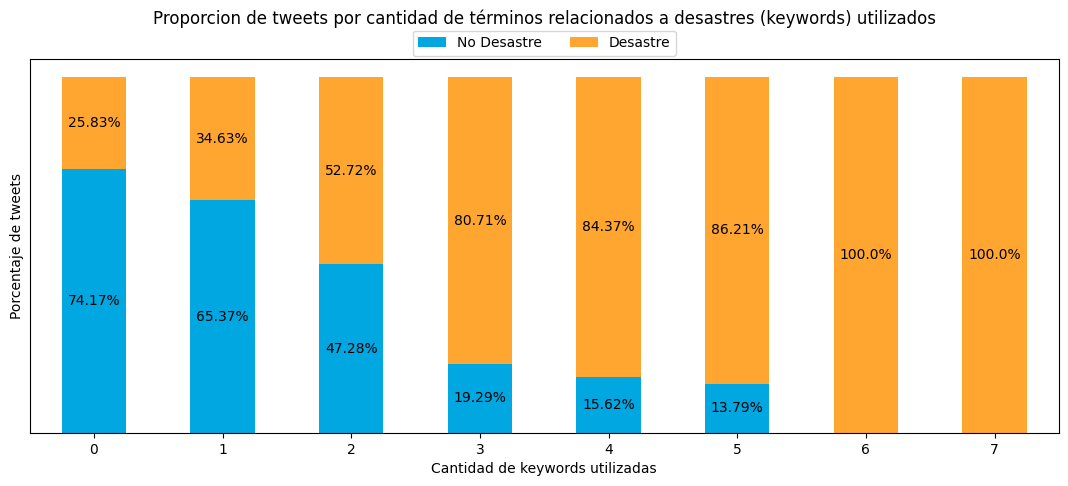

In [68]:
data = df.groupby(['disaster_terms_count','target'])["id"].nunique().unstack()
data.columns = ['No Desastre','Desastre']
data.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6), color=CUSTOM_PALLETE, ax=ax)

for c in ax.containers:
    labels = [str(round(v.get_height()*100, 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 10)
    
plt.title('Proporcion de tweets por cantidad de términos relacionados a desastres (keywords) utilizados', pad=25)
plt.tight_layout(pad=5)
plt.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.095))
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Porcentaje de tweets')
plt.yticks(ticks=[])
plt.xticks(rotation=0)
plt.show()

### 5. Distribución de sentimiento del tweet por target

In [69]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

C:\Users\Patricio\AppData\Local\Temp\ipykernel_17596\757631948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].map(lambda x: "No Desastre" if x == 0 else "Desastre")


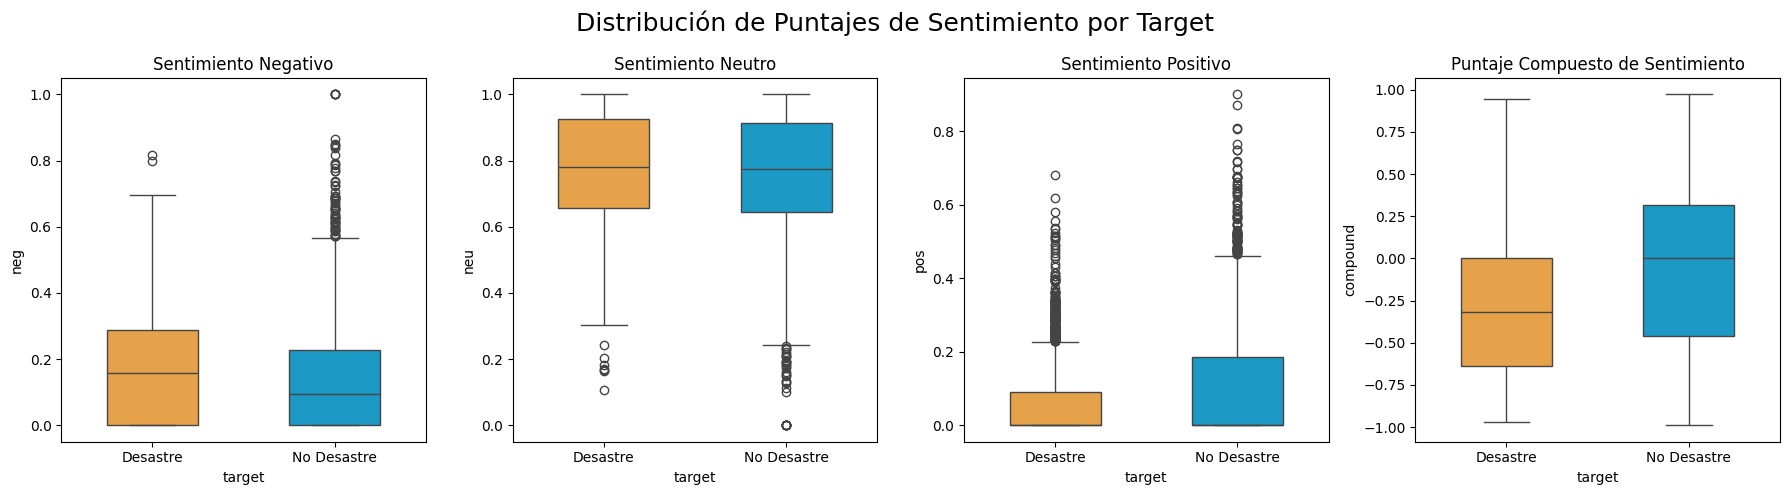

In [ ]:
data=df[['target','neg','neu','pos','compound']]
data['target'] = data['target'].map(lambda x: "No Desastre" if x == 0 else "Desastre")

cols = ['neg', 'neu', 'pos', 'compound']
colnames = {
    'neg': 'Negativo',
    'neu': 'Neutro',
    'pos': 'Positivo',
    'compound': 'Compuesto'
}

fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(18, 5))

for i, col in enumerate(cols):
    sns.boxplot(data=data, x='target', y=col, ax=axes[i], palette=CUSTOM_PALLETE[::-1], width=0.5)
    axes[i].set_ylabel('')
    if col != 'compound':
        axes[i].set_title(f"Sentimiento {colnames[col]}")
    else:
        axes[i].set_title("Puntaje Compuesto de Sentimiento")
fig.suptitle("Distribución de Puntajes de Sentimiento por Target", fontsize=18)

plt.tight_layout()
plt.show()

#### 6. Nubes de palabras para cada target

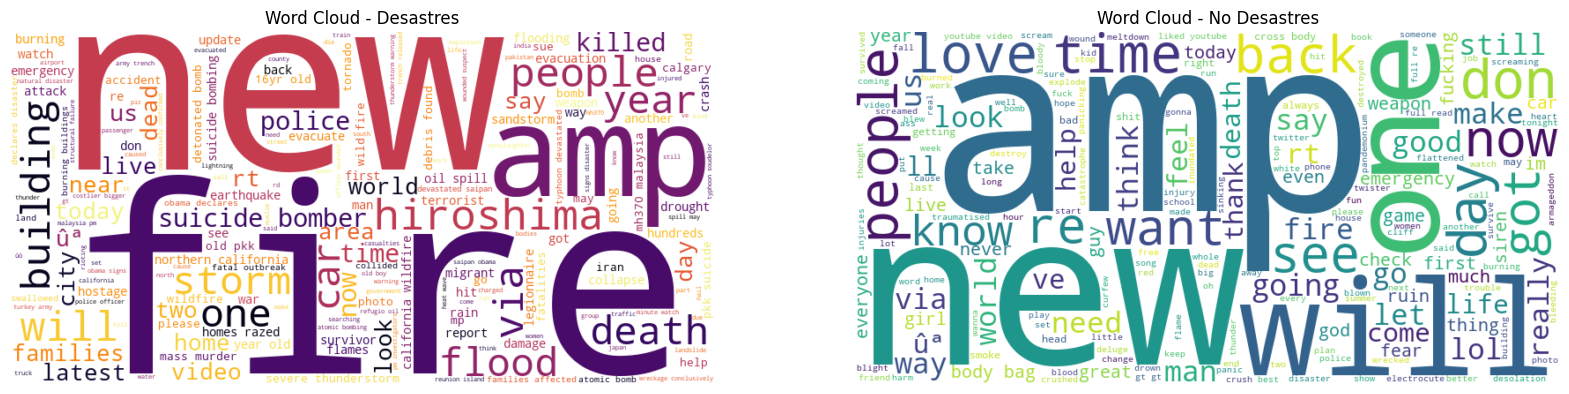

In [71]:
def generate_word_cloud(colormap, words):
    return WordCloud(
        width=800, height=400, background_color='white', random_state=SEED*2,
        min_word_length=2 ,colormap=colormap
    ).generate(words)
    
disaster_words = ' '.join(df[df['target']==1]['text_clean'].tolist())
not_disaster_words = ' '.join(df[df['target']==0]['text_clean'].tolist())
disaster_wc = generate_word_cloud("inferno", disaster_words)
not_disaster_wc = generate_word_cloud("viridis", not_disaster_words)
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes[0].imshow(disaster_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - Desastres')
axes[1].imshow(not_disaster_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - No Desastres')
plt.show()


### Análisis de palabras importantes usando TF-IDF + RandomForest
Entreno un RandomForest rápido sobre TF-IDF para extraer las palabras más importantes según el modelo. 
Esto es sólo para realizar un análisis exploratorio, no es el baseline.

F1 (val): 0.580952380952381


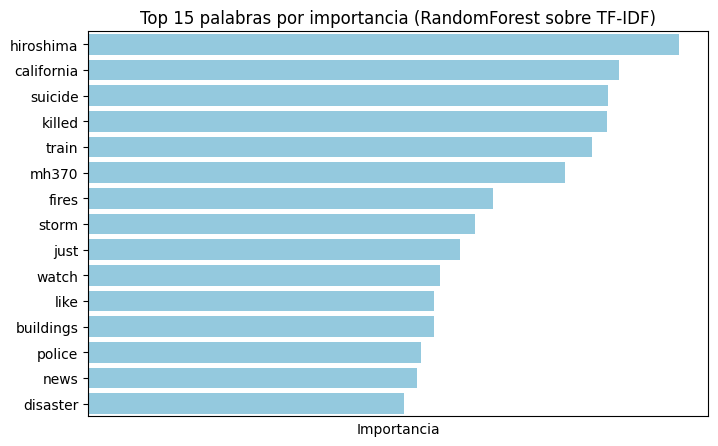

In [72]:
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], y, test_size=0.2, random_state=SEED)
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
vectorizer.fit(X_train)
X_tfidf = vectorizer.transform(X_train)

rf = RandomForestClassifier(n_estimators=50, random_state=SEED, n_jobs=-1)
rf.fit(X_tfidf, y_train)
val_tfidf = vectorizer.transform(X_val)
y_pred = rf.predict(val_tfidf)
print('F1 (val):', f1_score(y_val, y_pred))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
feat_names = np.array(vectorizer.get_feature_names_out())
top_words = feat_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8,5))
sns.barplot(x=top_importances, y=top_words, color='skyblue')
plt.title('Top 15 palabras por importancia (RandomForest sobre TF-IDF)')
plt.xlabel('Importancia')
plt.xticks(ticks=[])
plt.show()


In [73]:
dim_reduc = TSNE(n_components=2, random_state=SEED, perplexity=40)
X_embedded = dim_reduc.fit_transform(X_tfidf.toarray())


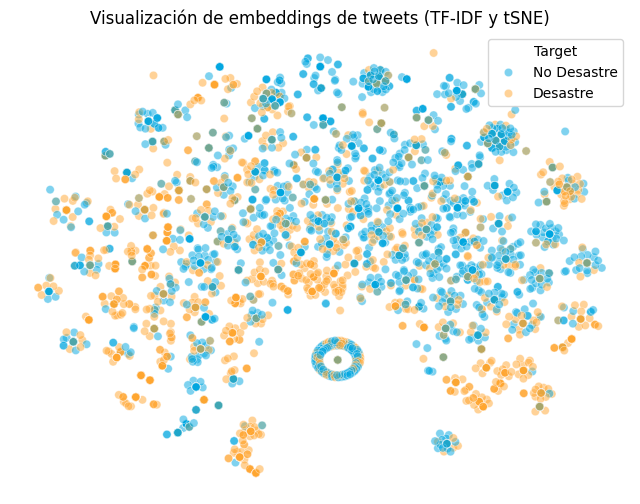

In [74]:
df_plot = pd.DataFrame({
    'x': X_embedded[:,0],
    'y': X_embedded[:,1],
    'target': ['Desastre' if t == 1 else 'No Desastre' for t in y_train]
})
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='target',
    palette=CUSTOM_PALLETE,
    alpha=0.5
)
plt.title("Visualización de embeddings de tweets (TF-IDF y tSNE)")
plt.legend(title='Target')
plt.axis('off')
plt.show()

In [75]:
w2v_path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [76]:
token_pattern = re.compile(r"\w+")
def tokenize(text):
    return token_pattern.findall(text)
tweet = df['text_clean'].astype(str).iloc[100]

print(f"Texto original: {tweet}")
print(f"Texto tokenizado: {tokenize(tweet)}")

Texto original: @norwaymfa #bahrain police had previously died in a road accident they were not killed by explosion
Texto tokenizado: ['norwaymfa', 'bahrain', 'police', 'had', 'previously', 'died', 'in', 'a', 'road', 'accident', 'they', 'were', 'not', 'killed', 'by', 'explosion']


In [77]:
import umap
feature_names = vectorizer.get_feature_names_out()
idf = dict(zip(feature_names, vectorizer.idf_))
max_idf = max(idf.values()) if idf else 1.0
tfidf_idf_norm = {w: idf.get(w, 0.0)/max_idf for w in idf}
tfidf_dict = tfidf_idf_norm

use_tfidf_weights = False
def sentence_vector_avg(tokens, model, dim):
    if use_tfidf_weights:
        vec = np.zeros(dim, dtype=float)
        w_sum = 0.0
        for w in tokens:
            wkey = w if w in model else (w.lower() if w.lower() in model else None)
            if wkey is None:
                continue
            tfidf_w = tfidf_dict.get(w, 0.0)
            vec += model[wkey] * tfidf_w
            w_sum += tfidf_w
        if w_sum == 0:
            return np.zeros(dim, dtype=float)
        return vec / w_sum
    else:
        if not tokens:
            return np.zeros(dim, dtype=float)
        vecs = []
        for w in tokens:
            if w in model:
                vecs.append(model[w])
            elif w.lower() in model:
                vecs.append(model[w.lower()])
        if len(vecs) == 0:
            return np.zeros(dim, dtype=float)
        return np.mean(vecs, axis=0)

texts = df['text_clean'].astype(str).tolist()
tokens_list = [tokenize(t) for t in texts]

vecs = []
labels = []
for i in range(len(tokens_list)):
    tokens = tokens_list[i]
    v = sentence_vector_avg(tokens, w2v, dim=w2v.vector_size)
    vecs.append(v)
    labels.append(int(df.iloc[i]['target']))

X = np.vstack(vecs)
dim_reduc = umap.UMAP(n_components=2, random_state=SEED)
X_2d = dim_reduc.fit_transform(X)

c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


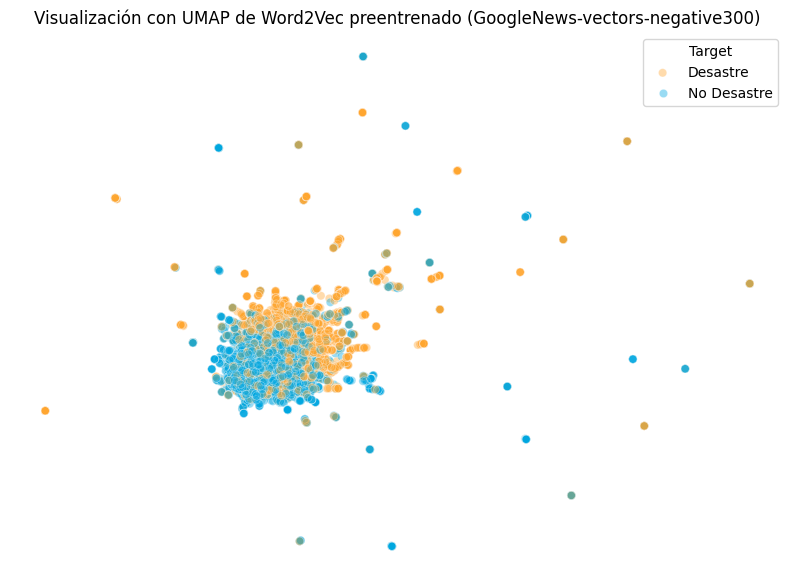

In [78]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_2d[:,0],
    y=X_2d[:,1],
    hue=labels,
    palette=CUSTOM_PALLETE,
    alpha=0.4
)
plt.title('Visualización con UMAP de Word2Vec preentrenado (GoogleNews-vectors-negative300)')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.axis('off')
plt.show()


In [83]:
from sentence_transformers import SentenceTransformer

texts = df['text_clean'].astype(str).tolist()
y = df['target'].astype(int).values

model_name = "all-MiniLM-L6-v2"
print("Cargando SentenceTransformer:", model_name)
sbert = SentenceTransformer(model_name)

Cargando SentenceTransformer: all-MiniLM-L6-v2


In [84]:
embeddings = sbert.encode(texts, show_progress_bar=True, batch_size=64, convert_to_numpy=True)

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Reduciendo dimensionalidad con UMAP...


c:\Users\Patricio\miniconda3\envs\jupyter_env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Done UMAP, shape: (7613, 2)


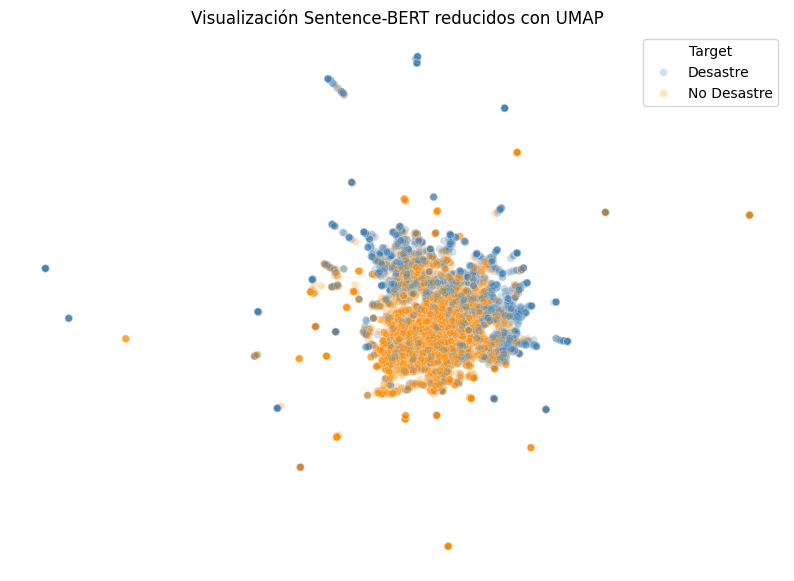

In [85]:
import umap

print("Reduciendo dimensionalidad con UMAP...")
reducer = umap.UMAP(n_components=2, random_state=SEED, metric='cosine')
X_2d = reducer.fit_transform(embeddings)
print("Done UMAP, shape:", X_2d.shape)

df_plot = pd.DataFrame({
    'x': X_2d[:,0],
    'y': X_2d[:,1],
    'target': y
})
df_plot['target_name'] = df_plot['target'].map({0: 'No Desastre', 1: 'Desastre'})

plt.figure(figsize=(10,7))
ax = sns.scatterplot(data=df_plot, x='x', y='y', hue='target_name',
                     palette=['steelblue', 'darkorange'], alpha=0.25, s=30)
ax.set_title("Visualización Sentence-BERT reducidos con UMAP")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.legend(title='Target')
plt.axis('off')
plt.show()
